# Part1: Load

In [5]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from numpy import arange
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from itertools import cycle
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold

## Part 2: EDA

In [7]:
train=pd.read_csv("../data/train.csv") #2000*21
test=pd.read_csv("../data/test.csv") #1000*21

In [8]:
df_Merge = train.append(test,sort=False)
df_Merge.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,id
0,842,0,2.2,0,1,0,7,0.6,188,2,...,756,2549,9,7,19,0,0,1,1.0,NaN
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,1988,2631,17,3,7,1,1,0,2.0,NaN
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1716,2603,11,2,9,1,1,0,2.0,NaN
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1786,2769,16,8,11,1,0,0,2.0,NaN
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1212,1411,8,2,15,1,1,0,1.0,NaN


### Merge train and test together

In [9]:
df_Merge.isnull().sum() # no price_range column for test data; no id column for train data

battery_power       0
blue                0
clock_speed         0
dual_sim            0
fc                  0
four_g              0
int_memory          0
m_dep               0
mobile_wt           0
n_cores             0
pc                  0
px_height           0
px_width            0
ram                 0
sc_h                0
sc_w                0
talk_time           0
three_g             0
touch_screen        0
wifi                0
price_range      1000
id               2000
dtype: int64

In [10]:
df_Merge = df_Merge.drop(['id'],axis=1) # Drop id column 

### EDA for whole data: Correlations of Each Features

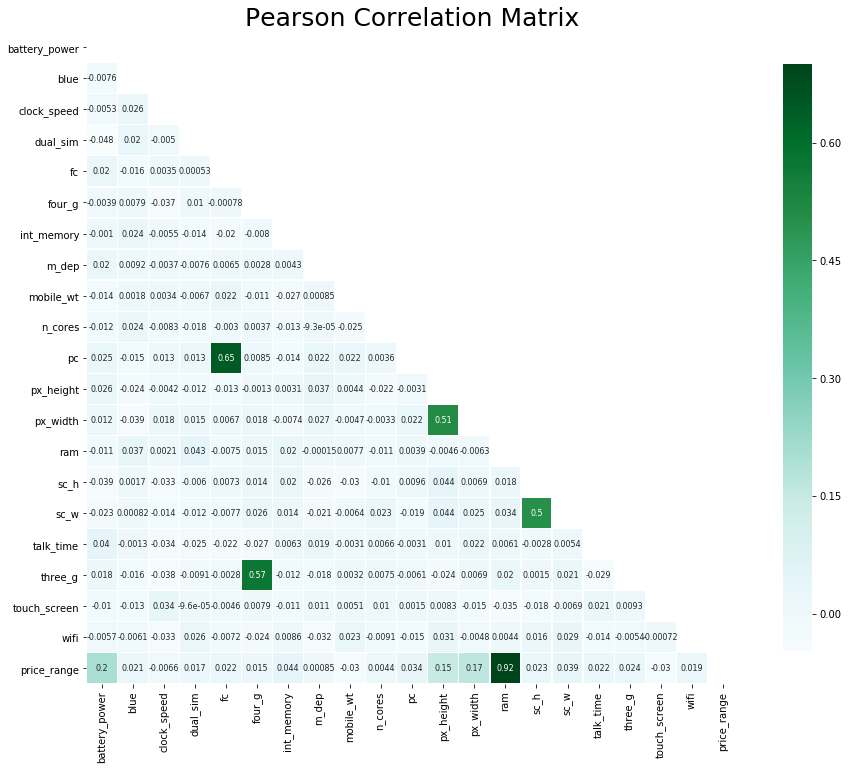

In [11]:
features = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 
            'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 
            'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 
            'three_g', 'touch_screen', 'wifi', 'price_range']

mask = np.zeros_like(df_Merge[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df_Merge[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn",
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9})
plt.show()

### EDA for whole data: price_range vs. ram

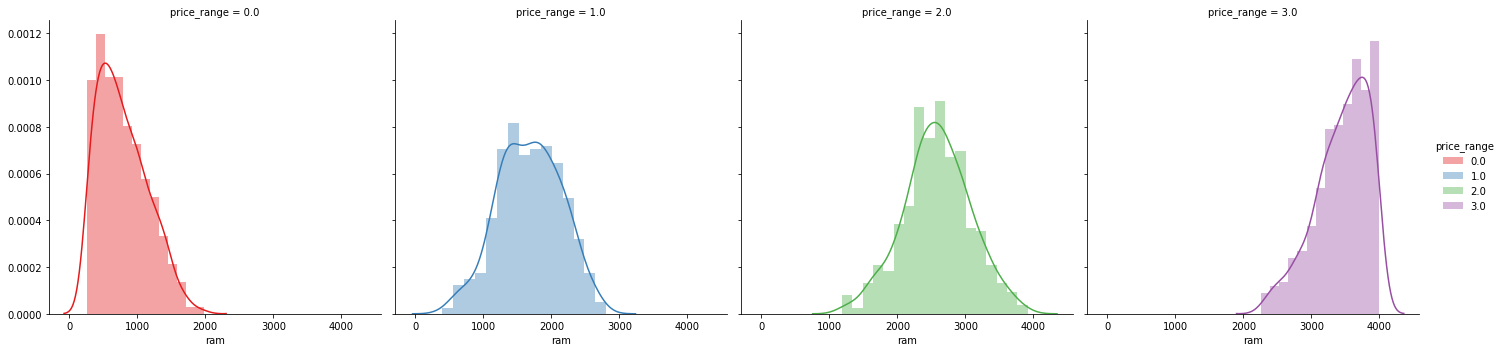

In [12]:
g = sns.FacetGrid(df_Merge, col="price_range", hue="price_range", palette="Set1",height=5 )
g = (g.map(sns.distplot, "ram").add_legend())

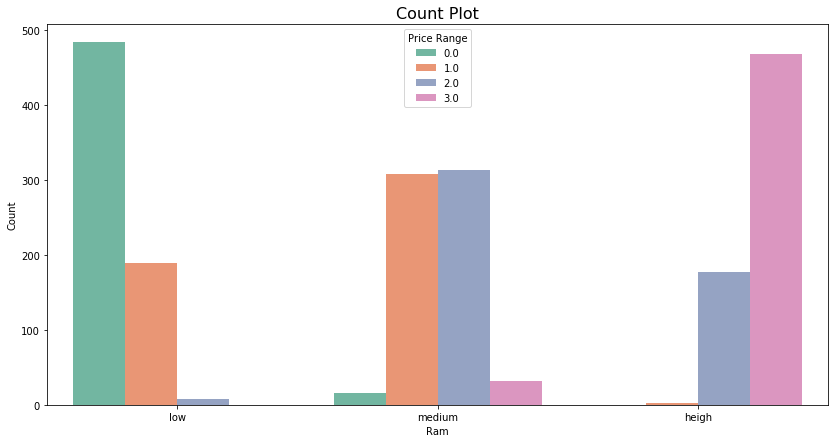

In [13]:
df_cut = pd.DataFrame()
df_cut["Ram"] = pd.cut(df_Merge["ram"],3,labels=["low","medium","heigh"])
df_cut["Price Range"] = df_Merge["price_range"]

plt.figure(figsize=(14,7))  
sns.countplot(data=df_cut,x="Ram",hue="Price Range",palette="Set2")
plt.title("Count Plot",fontsize=16)
plt.xlabel("Ram")
plt.ylabel("Count")
plt.show()

### EDA for whole data: price_range vs. battery_power

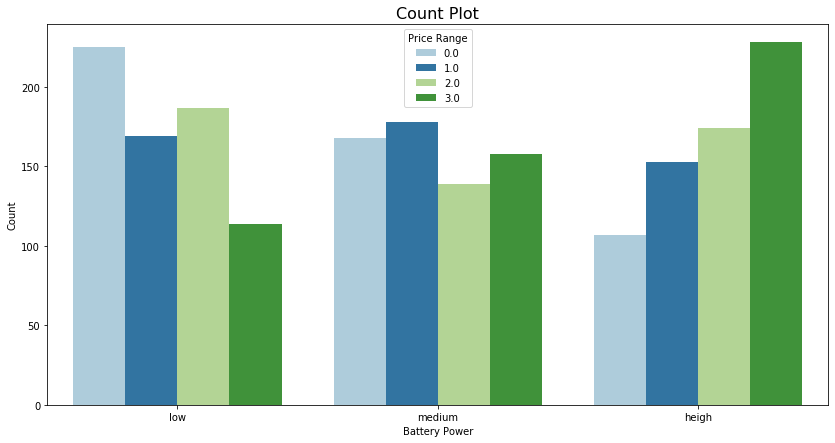

In [14]:
df_cut["Battery Power"] = pd.cut(df_Merge["battery_power"],3,labels=["low","medium","heigh"])
plt.figure(figsize=(14,7))  
sns.countplot(data=df_cut,x="Battery Power",hue="Price Range",palette="Paired")
plt.title("Count Plot",fontsize=16)
plt.xlabel("Battery Power")
plt.ylabel("Count")
plt.show()

### Scale columns

In [15]:
standardScaler = StandardScaler()
columns_to_scale = ['battery_power', 'clock_speed', 'int_memory', 'mobile_wt', 'px_height','px_width','ram','sc_h','sc_w','talk_time']
df_Merge[columns_to_scale] = standardScaler.fit_transform(df_Merge[columns_to_scale])

In [16]:
df_Train=df_Merge[0:2000]
df_Test=df_Merge[2000:]

In [17]:
df_Test = df_Test.drop(['price_range'],axis=1)

In [18]:
X=df_Train.drop(['price_range'],axis=1)
y=df_Train.price_range

### Test-train Split

In [19]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [20]:
x_temp_train1 = sm.add_constant(X_train)
vif_train1 = pd.DataFrame()
vif_train1["VIF Factor"] = [variance_inflation_factor(x_temp_train1.values, i) for i in range(x_temp_train1.values.shape[1])]
vif_train1["features"] = x_temp_train1.columns
vif_train1_a=vif_train1[vif_train1["VIF Factor"]<5.0]
feat_list=vif_train1_a["features"].tolist() 
# len(feat_list) = 20 # no serious multicollinearity

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Part 3: Models

## Model 1:  Naive Bayes

In [21]:
params = {}
#gridsearch searches for the best hyperparameters and keeps the classifier with the highest recall score
skf = StratifiedKFold(n_splits=10)

nb = GridSearchCV(GaussianNB(), cv=skf, param_grid=params)

%time nb.fit(X_train, y_train)
gnb_2 = nb.fit(X_train, y_train)
y_pred_nb2 = gnb_2.predict(X_test) 

print(accuracy_score(y_test, y_pred_nb2))

CPU times: user 90.4 ms, sys: 4.61 ms, total: 95 ms
Wall time: 124 ms
0.8266666666666667


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


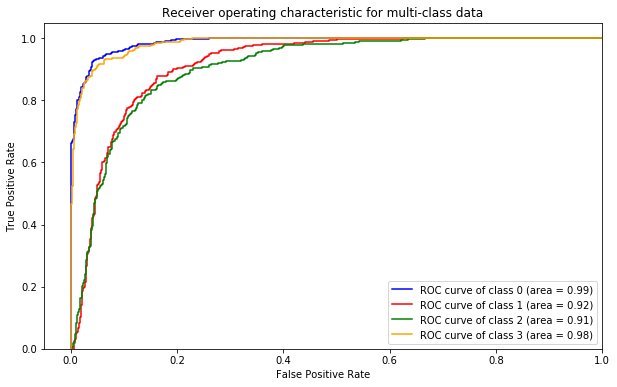

In [22]:
X1 = X_train.to_numpy()
y1 = y_train.to_numpy()

# Binarize the output
y_bin = label_binarize(y1, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

clf = gnb_2
y_score = cross_val_predict(clf, X1, y1, cv=10 ,method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','orange'])

plt.figure(figsize=(10,6))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',linewidth=0.001)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

## Model 2: Catboost

In [23]:
CB_Classifier = CatBoostClassifier(iterations=100,verbose=True,
                        learning_rate=0.20,depth=2,l2_leaf_reg=100,bagging_temperature=0.5)

%time CB_Classifier.fit(X_train, y_train,logging_level='Silent')
CB = CB_Classifier.fit(X_train, y_train,logging_level='Silent')

CPU times: user 384 ms, sys: 50.3 ms, total: 434 ms
Wall time: 381 ms


In [24]:
pred_CB = CB.predict(X_test)
print(accuracy_score(y_test, pred_CB))

0.845


0:	learn: 1.2779232	total: 3.15ms	remaining: 312ms
1:	learn: 1.2227806	total: 5.95ms	remaining: 291ms
2:	learn: 1.1373304	total: 22.6ms	remaining: 732ms
3:	learn: 1.0699975	total: 24.7ms	remaining: 593ms
4:	learn: 1.0147076	total: 27.4ms	remaining: 520ms
5:	learn: 0.9650586	total: 28.9ms	remaining: 453ms
6:	learn: 0.9325241	total: 30.4ms	remaining: 404ms
7:	learn: 0.8987827	total: 32.3ms	remaining: 372ms
8:	learn: 0.8638376	total: 34.2ms	remaining: 346ms
9:	learn: 0.8351448	total: 36.5ms	remaining: 329ms
10:	learn: 0.8110700	total: 38.6ms	remaining: 313ms
11:	learn: 0.7903610	total: 39.9ms	remaining: 293ms
12:	learn: 0.7684699	total: 41.1ms	remaining: 275ms
13:	learn: 0.7500673	total: 42.5ms	remaining: 261ms
14:	learn: 0.7383041	total: 43.7ms	remaining: 248ms
15:	learn: 0.7218665	total: 45ms	remaining: 236ms
16:	learn: 0.7080540	total: 46.3ms	remaining: 226ms
17:	learn: 0.6961678	total: 48.4ms	remaining: 220ms
18:	learn: 0.6867509	total: 50ms	remaining: 213ms
19:	learn: 0.6801153	total

70:	learn: 0.4297568	total: 251ms	remaining: 103ms
71:	learn: 0.4285103	total: 256ms	remaining: 99.5ms
72:	learn: 0.4269075	total: 266ms	remaining: 98.3ms
73:	learn: 0.4253524	total: 268ms	remaining: 94.1ms
74:	learn: 0.4239268	total: 270ms	remaining: 90ms
75:	learn: 0.4228055	total: 273ms	remaining: 86.1ms
76:	learn: 0.4192047	total: 293ms	remaining: 87.6ms
77:	learn: 0.4181932	total: 297ms	remaining: 83.9ms
78:	learn: 0.4152198	total: 305ms	remaining: 81.1ms
79:	learn: 0.4125408	total: 308ms	remaining: 76.9ms
80:	learn: 0.4111226	total: 310ms	remaining: 72.6ms
81:	learn: 0.4082763	total: 312ms	remaining: 68.5ms
82:	learn: 0.4073682	total: 320ms	remaining: 65.5ms
83:	learn: 0.4057167	total: 341ms	remaining: 65ms
84:	learn: 0.4046677	total: 346ms	remaining: 61ms
85:	learn: 0.4017991	total: 347ms	remaining: 56.5ms
86:	learn: 0.3988654	total: 357ms	remaining: 53.4ms
87:	learn: 0.3971477	total: 359ms	remaining: 49ms
88:	learn: 0.3962255	total: 361ms	remaining: 44.6ms
89:	learn: 0.3949737	

58:	learn: 0.4720646	total: 147ms	remaining: 102ms
59:	learn: 0.4678701	total: 150ms	remaining: 100ms
60:	learn: 0.4651288	total: 152ms	remaining: 96.9ms
61:	learn: 0.4611642	total: 153ms	remaining: 93.7ms
62:	learn: 0.4595835	total: 154ms	remaining: 90.6ms
63:	learn: 0.4575042	total: 156ms	remaining: 88ms
64:	learn: 0.4539726	total: 160ms	remaining: 86ms
65:	learn: 0.4523852	total: 162ms	remaining: 83.3ms
66:	learn: 0.4502417	total: 177ms	remaining: 87ms
67:	learn: 0.4462033	total: 182ms	remaining: 85.7ms
68:	learn: 0.4438879	total: 186ms	remaining: 83.7ms
69:	learn: 0.4410271	total: 188ms	remaining: 80.6ms
70:	learn: 0.4376398	total: 192ms	remaining: 78.3ms
71:	learn: 0.4358203	total: 194ms	remaining: 75.4ms
72:	learn: 0.4342575	total: 195ms	remaining: 72.3ms
73:	learn: 0.4329318	total: 197ms	remaining: 69.2ms
74:	learn: 0.4310024	total: 198ms	remaining: 66.1ms
75:	learn: 0.4298223	total: 200ms	remaining: 63.3ms
76:	learn: 0.4287273	total: 202ms	remaining: 60.5ms
77:	learn: 0.4262789

22:	learn: 0.6517362	total: 65.2ms	remaining: 218ms
23:	learn: 0.6432285	total: 67.4ms	remaining: 213ms
24:	learn: 0.6337912	total: 69.1ms	remaining: 207ms
25:	learn: 0.6275988	total: 70.9ms	remaining: 202ms
26:	learn: 0.6191411	total: 72.9ms	remaining: 197ms
27:	learn: 0.6093292	total: 75.2ms	remaining: 193ms
28:	learn: 0.6010465	total: 77.5ms	remaining: 190ms
29:	learn: 0.5932903	total: 79.7ms	remaining: 186ms
30:	learn: 0.5859380	total: 81.7ms	remaining: 182ms
31:	learn: 0.5796997	total: 85.3ms	remaining: 181ms
32:	learn: 0.5738364	total: 91.4ms	remaining: 186ms
33:	learn: 0.5676310	total: 95.2ms	remaining: 185ms
34:	learn: 0.5627859	total: 110ms	remaining: 205ms
35:	learn: 0.5575363	total: 112ms	remaining: 199ms
36:	learn: 0.5550533	total: 113ms	remaining: 193ms
37:	learn: 0.5492315	total: 115ms	remaining: 188ms
38:	learn: 0.5469448	total: 117ms	remaining: 182ms
39:	learn: 0.5412123	total: 118ms	remaining: 177ms
40:	learn: 0.5384994	total: 120ms	remaining: 172ms
41:	learn: 0.535242

84:	learn: 0.4126769	total: 267ms	remaining: 47.2ms
85:	learn: 0.4108457	total: 276ms	remaining: 44.9ms
86:	learn: 0.4094284	total: 278ms	remaining: 41.5ms
87:	learn: 0.4075583	total: 282ms	remaining: 38.5ms
88:	learn: 0.4059539	total: 288ms	remaining: 35.7ms
89:	learn: 0.4028404	total: 306ms	remaining: 34ms
90:	learn: 0.4021455	total: 308ms	remaining: 30.5ms
91:	learn: 0.3992131	total: 311ms	remaining: 27ms
92:	learn: 0.3963342	total: 313ms	remaining: 23.6ms
93:	learn: 0.3949934	total: 317ms	remaining: 20.3ms
94:	learn: 0.3924506	total: 329ms	remaining: 17.3ms
95:	learn: 0.3901937	total: 331ms	remaining: 13.8ms
96:	learn: 0.3885636	total: 351ms	remaining: 10.9ms
97:	learn: 0.3877168	total: 361ms	remaining: 7.36ms
98:	learn: 0.3855798	total: 363ms	remaining: 3.67ms
99:	learn: 0.3854418	total: 365ms	remaining: 0us
0:	learn: 1.2824038	total: 3.33ms	remaining: 330ms
1:	learn: 1.1945822	total: 4.83ms	remaining: 237ms
2:	learn: 1.1211654	total: 6.27ms	remaining: 203ms
3:	learn: 1.0558393	to

77:	learn: 0.4332388	total: 190ms	remaining: 53.6ms
78:	learn: 0.4303508	total: 195ms	remaining: 51.8ms
79:	learn: 0.4290664	total: 197ms	remaining: 49.2ms
80:	learn: 0.4281058	total: 203ms	remaining: 47.5ms
81:	learn: 0.4266564	total: 205ms	remaining: 44.9ms
82:	learn: 0.4236154	total: 212ms	remaining: 43.5ms
83:	learn: 0.4221711	total: 224ms	remaining: 42.7ms
84:	learn: 0.4202336	total: 227ms	remaining: 40ms
85:	learn: 0.4184120	total: 248ms	remaining: 40.4ms
86:	learn: 0.4173546	total: 252ms	remaining: 37.7ms
87:	learn: 0.4142944	total: 263ms	remaining: 35.8ms
88:	learn: 0.4130327	total: 266ms	remaining: 32.9ms
89:	learn: 0.4102220	total: 273ms	remaining: 30.3ms
90:	learn: 0.4091236	total: 278ms	remaining: 27.5ms
91:	learn: 0.4064117	total: 281ms	remaining: 24.4ms
92:	learn: 0.4039014	total: 290ms	remaining: 21.8ms
93:	learn: 0.4013879	total: 292ms	remaining: 18.7ms
94:	learn: 0.4001294	total: 295ms	remaining: 15.5ms
95:	learn: 0.3993393	total: 298ms	remaining: 12.4ms
96:	learn: 0.3

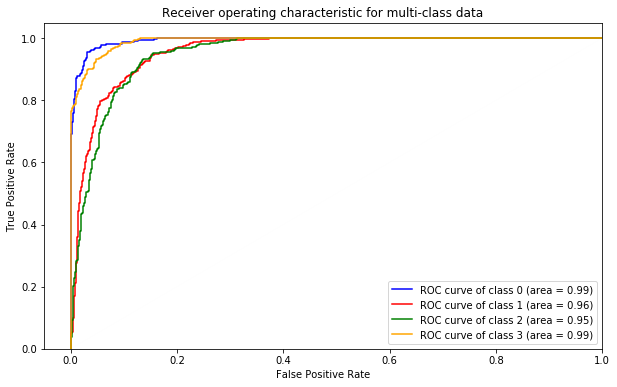

In [25]:
X1 = X_train.to_numpy()
y1 = y_train.to_numpy()

# Binarize the output
y_bin = label_binarize(y1, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

y_score = cross_val_predict(CB, X1, y1, cv=10, method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','orange'])

plt.figure(figsize=(10,6))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',linewidth=0.001)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

## Model 3: QDA

In [26]:
estimator_3 = QuadraticDiscriminantAnalysis()
parameters_3 = {
    'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
    'store_covariance': (True, False),
    'tol': (0.0001, 0.001,0.01, 0.1), 
                   }
# with GridSearch
grid_search_qda = GridSearchCV(
    estimator=estimator_3,
    param_grid=parameters_3,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)
%time grid_search_qda.fit(X_train, y_train)
qda = grid_search_qda.fit(X_train, y_train)
pred_qda =qda.predict(X_test)

print(accuracy_score(y_test, pred_qda))

CPU times: user 595 ms, sys: 112 ms, total: 706 ms
Wall time: 5.47 s
0.9283333333333333


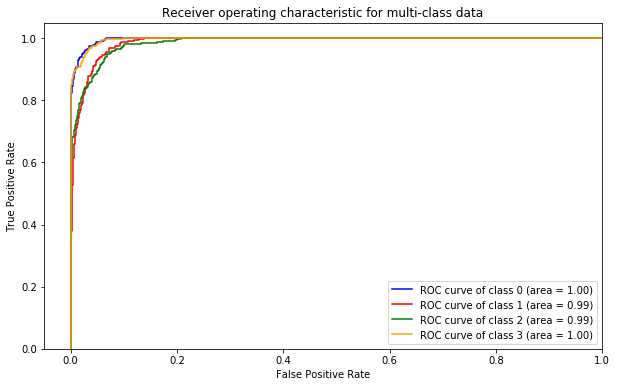

In [27]:
X1 = X_train.to_numpy()
y1 = y_train.to_numpy()

# Binarize the output
y_bin = label_binarize(y1, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

clf = qda
y_score = cross_val_predict(clf, X1, y1, cv=10 ,method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','orange'])

plt.figure(figsize=(10,6))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',linewidth=0.001)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


## Model 4: KNN

In [28]:
def train_knn(feature_train,label_train,n_neighbors):
    # Input: feature data frame, label series, model parameters
    # Output: time to train model, trained model
    start = time.time()
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(feature_train,label_train)
    end = time.time()
    train_time = end-start
    return [train_time,knn]

In [29]:
run_knn = True
feature_train,feature_test,label_train,label_test=train_test_split(train,y,test_size=0.3)

In [30]:
def compute_metrics(feature_test,label_test,test_preds, model):
    classification_error = np.mean(np.array(test_preds) != np.array(label_test))
    accuracy = 1-classification_error
    test_probs = model.predict_proba(feature_test)[:,1]
    return [accuracy]

def test_model(model, feature_test):
    # Input: test features, a trained model
    # Output: prediction time, test predictions
    start = time.time()
    test_preds = model.predict(feature_test)
    end = time.time()
    prediction_time = end-start
    return [prediction_time,test_preds]

In [31]:
if run_knn == True:    
    [train_time, knn] = train_knn(feature_train,label_train,n_neighbors=25)
    print('\nTraining time: {:4f} seconds'.format(train_time))

    [prediction_time,test_preds] = test_model(knn,feature_test)
    print('Prediction time: {:4f} seconds'.format(prediction_time))
    
    [accuracy] = compute_metrics(feature_test,label_test,test_preds,knn)
    print('\nAccuracy: {:4f}'.format(accuracy))
    #print('AUC: {:4f}'.format(auc))
    
    row = pd.Series({#'Feature Extraction Train Time':tm_feature_train_improved,
        #'Feature Extraction Test Time':tm_feature_test_improved,
         'Train Time':train_time,
         'Prediction Time':prediction_time,
        'Accuracy':accuracy},name='KNN')


Training time: 0.005395 seconds
Prediction time: 0.059870 seconds

Accuracy: 0.935000


## Model 5: LDA

In [35]:
model = LDA(solver='eigen')
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['shrinkage'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
y_pred=search.predict(X_test)
# summarize
print(accuracy_score(y_test, y_pred))
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

0.9483333333333334
Mean Accuracy: 0.939
Config: {'shrinkage': 0.0}


## Model 6:

## Model 7:

## Model 8:

## Model 9: